# Dynamics 365 Business Central Trouble Shooting Guide (TSG) - Performance analysis (overview)

This notebook contains Kusto queries that can help getting to the root cause of a performance issue for an environment. Each section in the notebook contains links to the performance tuning guide on docs [aka.ms/bcperformance](aka.ms/bcperformance),  links to the documentation of relevant telemetry in [aka.ms/bctelemetry](aka.ms/bctelemetry), as well as Kusto queries that help dive into a specific area (sessions, web service requests, database calls, reports, and page load times).

NB! Some of the signal used in this notebook is only available in newer versions of Business Central, so check the version of your environment if some sections do not return any data. The signal documentation states in which version a given signal was introduced.

## 1. Connect to Application Insights
First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it?) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


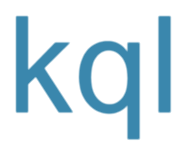

In [1]:
# load the KQLmagic module
%reload_ext Kqlmagic

# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2. Define filters
This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId and environmentName: 

In [2]:
aadTenantId = "<Add AAD tenant id here>"
environmentName = "<add environment name here>"

# Analyze performance
Now you can run Kusto queries to look for possible root causes for performance issues.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Sessions

Performance tuning guide: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-online#telemetry

Session telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-authorization-trace#authorization-succeeded-open-company

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Authorization.kql

In [3]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0004'
    and timestamp > ago(7d)
| extend clientType = tostring( customDimensions.clientType )
| summarize request_count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of sessions by client type'

In [4]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0004'
    and timestamp > ago(7d)
| extend clientType = tostring( customDimensions.clientType )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000000
| summarize _count=count() by executionTimeInSeconds = bin(executionTimeInSec, 1), clientType
| extend log_count = log10( _count )
| order by clientType, executionTimeInSeconds asc
| render columnchart with  (ycolumns = log_count, series = clientType, title= 'Execution time (in seconds) of session login time by client type', ytitle = 'log(count)') 

## Web service requests

Performance tuning guide: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services

Web service telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql

In [5]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0008'
    and timestamp > ago(7d)
| extend category = tostring( customDimensions.category )
| summarize request_count=count() by category, bin(timestamp, 1d)
| render timechart title= 'Number of web service requests by category'

In [6]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0008'
    and timestamp > ago(7d)
| extend category = tostring( customDimensions.category )
       , executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
| summarize count=count() by executionTime_ms = bin(executionTimeInMS, 100), category
| order by category, executionTime_ms asc
| render columnchart with  (ycolumns = count, series = category, title= 'Execution time (in milliseconds) of web service requests by category' ) 


## Data related

Performance tuning guide: 
* [Efficient data access](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#efficient-data-access)
* [Avoid locking](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-application#avoid-locking)

Database telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace

KQL samples:
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Long%20Running%20SQL%20Queries.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/LockTimeouts.kql


In [7]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0005'
    and timestamp > ago(7d)
| summarize count() by bin(timestamp, 1d)
| render timechart title= 'Number of long running SQL queries'

In [8]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0012'
    and timestamp > ago(7d)
| summarize request_count=count() by bin(timestamp, 1d)
| render timechart title= 'Number of database lock timeouts'

## Company management

Operations such as "copy company" can cause performance degradations if they are done when users are logged into the system.

Read more in the performance tuning guide here: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-application#be-cautious-with-the-renamecopy-company-operations

Telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-company-lifecycle-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/CompanyLifecycle.kql



In [9]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId in  ('LC0001')
    and timestamp > ago(7d)
| extend operation_type = case(
    customDimensions.eventId == 'LC0001', 'Company created',
    customDimensions.eventId == 'LC0004', 'Company copied',
    customDimensions.eventId == 'LC0007', 'Company deleted',    
    'Other'
)
| summarize count() by operation_type, bin(timestamp, 1d)
| render timechart title= 'Company management operations'

## Reports

Learn more about how to write performant reports here in the performance tuning guide: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-reports

Report telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-reports-trace

KQL samples:
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Reports.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/PerformanceTuning/ReportExecution.kql

In [10]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0006'
    and timestamp > ago(7d)
| extend clientType = tostring( customDimensions.clientType )
       , reportName = tostring( customDimensions.alObjectName )
| where reportName <> ''
| summarize count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of reports executed (shown by client/session type)'

In [11]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
    and customDimensions.environmentName == _environmentName
    and customDimensions.eventId == 'RT0006'
    and timestamp > ago(7d)
| extend reportName = tostring( customDimensions.alObjectName )
       , executionTimeInSec = toreal(totimespan(customDimensions.totalTime))/10000000 //the datatype for totalTime is timespan 
| where reportName <> ''
| summarize avg=avg(executionTimeInSec), median=percentile(executionTimeInSec, 50), percentile95=percentile(executionTimeInSec, 95), max=max(executionTimeInSec)   
  by reportName
| order by percentile95
| limit 10
| render columnchart with  (title= 'Execution time stats of reports by report name (top 10 by 95% percentile)', ytitle='Time (in seconds)' ) 

## Page views

Page view telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-page-view-trace

KQL samples
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/PageViews.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/BrowserUsage.kql

In [12]:
%%kql
// Top 10 longest page times 
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
pageViews
| where 1==1 
    and customDimensions.aadTenantId == _aadTenantId
//    and customDimensions.environmentName == _environmentName
| where timestamp > ago(7d)
| extend objectId = tostring(customDimensions.alObjectId)
| summarize median_load_time_in_MS = percentile(duration,50) by pageName=name, objectId
| order by median_load_time_in_MS desc
| limit 10